In [1]:
import pandas as pd
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import numpy as np
from scipy.stats import pearsonr
%matplotlib inline

warnings.filterwarnings("ignore")

In [2]:
domains = ['brand', 'good', 'trait', 'food', 'occupation', 'risk', 'people']

In [3]:
dict_of_dfs = dict()
for domain in domains:
#     df = pd.read_excel('data/mega results.xlsx', sheet_name=domain, header=None)
    df = pd.read_excel('data/mega results_with_completion_times.xlsx', sheet_name=domain, header=None)
    df.columns = ['Judgment','Word'] + [f'Participant_{n}' for n in range(len(df.columns) - 2)]
    df = df.set_index(['Judgment','Word']).T
    dict_of_dfs[domain] = df
dict_of_dfs[domain].head()

Judgment,warm,competent,warm,competent,warm,competent,warm,competent,warm,competent,...,warm,competent,warm,competent,warm,competent,warm,competent,completion_time,prolific_id
Word,Frank Sinatra,Frank Sinatra,Confucius,Confucius,Eric Clapton,Eric Clapton,Judy Garland,Judy Garland,Alex Ferguson,Alex Ferguson,...,Herbert Hoover,Herbert Hoover,Sean Connery,Sean Connery,Diana Ross,Diana Ross,Mitt Romney,Mitt Romney,completion_time,prolific_id
Participant_0,-1,34,36,76,46,73,78,63,NaN,NaN,...,1,32,30,83,51,77,1,36,1821,5ac69171a3ba7a0001b4b703
Participant_1,64,59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-50,-22,1583,5b6e9ff090cf8e0001acf303
Participant_2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,56,18,NaN,NaN,8,-31,1554,5b2464337297750001c6ce7a
Participant_3,-15,62,2,62,-15,51,-21,57,1,55,...,2,25,2,25,-1,29,2,25,1765,5a9aa65f89de8200013f06a4
Participant_4,-64,23,5,73,45,13,82,40,NaN,NaN,...,9,10,19,68,39,14,16,19,1282,58f3a00b92ac81000154f8e6


# Check distribution of completion times

In [4]:
all_domain_completion_times = []
for domain in domains:
    domain_completion_times = list(dict_of_dfs[domain]['completion_time']['completion_time'].apply(lambda x: int(x)/60))
    all_domain_completion_times.extend(domain_completion_times)
    
np.mean(all_domain_completion_times)

38.70328638497653

In [5]:
np.median(all_domain_completion_times)

33.833333333333336

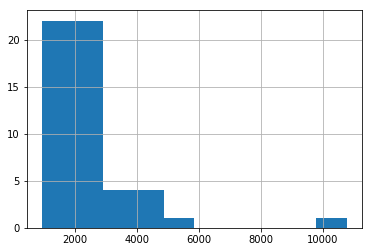

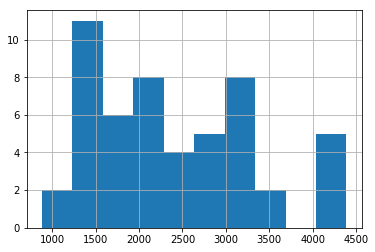

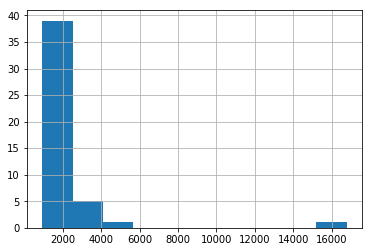

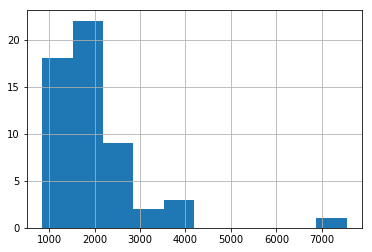

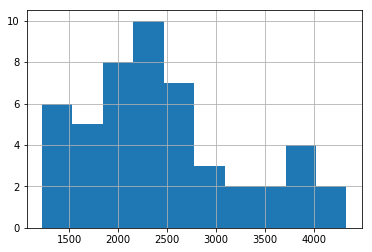

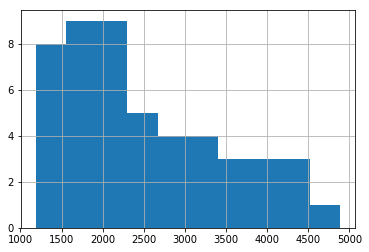

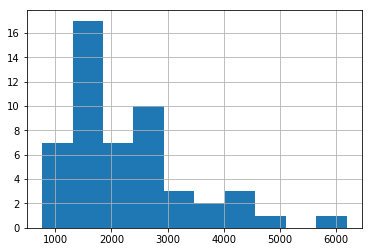

In [6]:
for domain in domains:
    dict_of_dfs[domain]['completion_time']['completion_time'].apply(int).hist()
    plt.show()

Some participants over 3600 seconds (1 hour) and need to be excluded on basis of timing.

In [7]:
acceptable_completion_time = 3600

parts_excluded_per_domain = []
for domain in domains:
    parts_with_okay_time = dict_of_dfs[domain]['completion_time']['completion_time'] < acceptable_completion_time # have completion time twice bc of multi-index
    parts_excluded = sum(~parts_with_okay_time)
    dict_of_dfs[domain] = dict_of_dfs[domain][parts_with_okay_time].drop(['completion_time', 'prolific_id'], axis='columns')
    parts_excluded_per_domain.append(parts_excluded)
print(parts_excluded_per_domain)
print(np.mean(parts_excluded_per_domain))

[9, 5, 2, 3, 6, 9, 6]
5.714285714285714


# Check rates of missing values

**Within a single item, sometimes a participant may provide one judgment while indicating “don’t know” for the other. This complicates counting "don't know" judgments by participant and item.**

Let's see how often this happened.

In [8]:
count_of_split_judgments_all_domains = []
for domain in domains:
    df = dict_of_dfs[domain]
    first_judgment  = df.iloc[:,::2].isna()
    second_judgment = df.iloc[:,1::2].isna()
    gave_split_judgment = np.logical_xor(first_judgment, second_judgment)
    count_of_split_judgments = gave_split_judgment.sum(axis=1).values
    count_of_split_judgments_all_domains.append(count_of_split_judgments)
split_judgment_counts_df = pd.DataFrame(count_of_split_judgments_all_domains, index=domains)
split_judgment_counts_df

,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,50,51
brand,0,0,0,0,0,0,0,0,0,0,...,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
good,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN
trait,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
food,1,0,10,3,0,0,0,11,9,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
occupation,0,0,0,0,0,0,1,0,0,0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
risk,0,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
people,0,29,2,0,0,15,0,0,0,0,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Below is the count of participants, per domain, that made *at least one* split judgment.

In [9]:
split_judgment_counts_df.applymap(bool).sum(axis='columns')

brand          8
good           9
trait         10
food          11
occupation    11
risk          20
people        17
dtype: int64

Below is the count of split judgments, per domain.

In [10]:
split_judgment_counts_df.sum(axis='columns')

brand           1.0
good           87.0
trait           8.0
food           88.0
occupation      2.0
risk          180.0
people        163.0
dtype: float64

Below indicates the total number of times participants made split judgments.

In [11]:
split_judgment_counts_df.sum().sum()

529.0

Considering that there are ~70,000 (7 domains * ~50 participants per domain * 200 items per participant) individual occasions on which participants could have made split judgments, this figure is very small (<1%). So, whether we count split judgments as knowing the item or not probably doesn't matter much. **For now, for the purposes of our pre-registered exclusion criteria, I'm going to count them as knowing the item.**

**This is something we should probably note in the supplemental materials -- that our exclusion criteria were too vague to specify how to handle split judgments.**

## Counts of unfamiliarity by participant

In [12]:
for domain in domains:
    print(domain)
    df = dict_of_dfs[domain]
    first_judgment_is_na  = df.iloc[:,::2].isna()
    second_judgment_is_na = df.iloc[:,1::2].isna()
    gave_neither_judgment = np.logical_and(first_judgment_is_na, second_judgment_is_na)
    unfamiliar_count_per_participant = gave_neither_judgment.sum(axis=1).values
    print(unfamiliar_count_per_participant)

brand
[ 88  30   7  36  23   7  12   3  17  39   6  64  14   1  90  20   0 118
  23   7   0  71  31   9  20  27  40  46  21   4  24  13  88  31 115  43
  49  25  69 119  59  50  35  51  23]
good
[ 2  5  0  0  2  4  0  2  5  2  6  0  0  0  0  0  0  3 15  3 10  0  0  8
  1  4  7  0  0  0  0  8  0  0  4  0 13  0  1  0  3  1 11  1  1  2]
trait
[27 38 40 27 26 25 23 28 27 28 48 30 25 26 25 29 28 25 26 34 27 29 25 27
 25 29 25 25 25 30 27 27 25 30 28 25 29 29 28 28 29 22  0  0]
food
[ 55  83  61  69  46  74  40 110  43  96  98  53  86  66  66 107  28  76
  26   0  95  76  62  80  68  75  41  50  59  41  47  99  24  32  70 130
 109  81  21  97  59  78 113  85  28  42  74  79  44  58 104  62]
occupation
[ 0  8  7 16  6  0 21  0  0  3  0  5 68  2  0  4  2  4  0  0  6 11 29  0
  7  8  0 17  4 27 11 50 16  0  3  0  0  0  0 11  0  3  4]
risk
[ 3  1  0  1  1  1  6  2  5  4  0  0  1  1  0  0  0  7  7  2  0  2 14  0
  1  6  0  3  0 12  1  0  3  0  5 12 71  0  5  0]
people
[ 15 112  95  16  31  99  17

In [13]:
# for domain in domains:
#     print(domain)
#     df = dict_of_dfs[domain]
#     # just get one judgment per domain, under assumption that people indicated 
#     # being unfamiliar with item for both, e.g., taste and nutrition...hence the iloc[:,::2] below and elsewhere
#     unfamiliar_count_per_participant = df.iloc[:,::2].isna().sum(axis=1).values
#     print(unfamiliar_count_per_participant)

Brands, foods, and people have a lot of items people found unfamiliar.

People ought to be excluded under our pre-reg criterion of being unfamiliar with more than 25% of the items.

In [14]:
numb_items = 200

dict_of_excludable_participants = dict()
for domain in domains:
    df = dict_of_dfs[domain]
    first_judgment_is_na  = df.iloc[:,::2].isna()
    second_judgment_is_na = df.iloc[:,1::2].isna()
    gave_neither_judgment = np.logical_and(first_judgment_is_na, second_judgment_is_na)
    unfamiliar_count_per_participant = gave_neither_judgment.sum(axis=1).values
#     unfamiliar_count_per_participant = df.iloc[:,::2].isna().sum(axis=1).values
    ought_to_exclude_participants = ((unfamiliar_count_per_participant / numb_items) > .25)
    print(domain, sum(ought_to_exclude_participants), sep='\t\t')
    dict_of_excludable_participants[domain] = ought_to_exclude_participants

brand		11
good		0
trait		0
food		36
occupation		1
risk		1
people		16


**Most participants are eliminated from the food category, by our pre-reg criteria! A substantial number from brands and people as well!**

## Missing values by item

In the below, each entry is the number of people who indicated that item was unfamiliar.

In [15]:
for domain in domains:
    print(domain)
    df = dict_of_dfs[domain]
    first_judgment_is_na  = df.iloc[:,::2].isna()
    second_judgment_is_na = df.iloc[:,1::2].isna()
    gave_neither_judgment = np.logical_and(first_judgment_is_na, second_judgment_is_na)
    unfamiliar_count_per_item = gave_neither_judgment.sum(axis='index').values
    print(unfamiliar_count_per_item)

brand
[ 9  0  0  2 28 17 11  2 14  0  9 14 14  7  9  7  1  2  4 19 22  0 12  8
  5 11 10 10  9 20 13 24  4  6  4  5 10  3  1  7  2  6 22  8  7 23  4  2
  8 17 24 27  2 12 12 17  7  7  2 18  6 29 13  4  1  9 20 14 36  1 10  5
  4  8  8  3 16  0 31  4  0 10  6 23 17 11  9  2  5  3  1 18  0  5  0  2
  7 11  5  3  5  0  1  7  2 23  6  8  2  3 14 11  5  2  2 15  0  3  7  0
 15  1  0  6  0  0 12 12 10 13  0  8  2 27  1 10  7  2 21 21  0  1  1  3
  1  2 11  8  2  5  3  0 33 22 13  7 17  5  9 11  0  7  2 21  7 28  6 17
  1 18  0  4 12  1  1 20  8  2  0  2  0  9 22  4  7  0  0  0  9  5  6  2
  6 12  0 29  0 10  3  9]
good
[ 0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0 12  0  0  0  0  1  0  0  1  0  0  0  0  0  0  0 15  0  0  0  1  0  0
  0  3  0  1  0  0  2  0  0  7  0  0  5  0  0  0  0  0  0  0  0  0  0  0
  0  0  1  3  0  1  2  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0
  0  0  1  2  2  0  0  0  2  0  0 11  2  0  0  0  0  0  0  0  0  1  5  0
  0  1  0  1  

In [16]:
# for domain in domains:
#     print(domain)
#     df = dict_of_dfs[domain]
#     unfamiliar_count_per_item = df.iloc[:,::2].isna().sum(axis=0).values
#     print(unfamiliar_count_per_item)

An item ought be excluded if more than 75% of participants indicated being unfamiliar with it.

In [17]:
dict_of_excludable_items = dict()
for domain in domains:
    df = dict_of_dfs[domain]
    numb_participants = df.shape[0]
    first_judgment_is_na  = df.iloc[:,::2].isna()
    second_judgment_is_na = df.iloc[:,1::2].isna()
    gave_neither_judgment = np.logical_and(first_judgment_is_na, second_judgment_is_na)
    unfamiliar_count_per_item = gave_neither_judgment.sum(axis='index').values    
    ought_to_exclude_items = ((unfamiliar_count_per_item / numb_participants) > .75)
    print(domain, sum(ought_to_exclude_items), sep='\t\t')
    
    # ought_to_exclude_items is 200 long, but to mask each domain's df, it needs to be 400 long, i.e., twice as long
    dict_of_excludable_items[domain] = np.repeat(ought_to_exclude_items, 2)

brand		1
good		0
trait		0
food		38
occupation		0
risk		0
people		3


**Not too many items are dropped by our pre-reg criteria, even for foods.**

# Dropping items and participants by pre-registration criteria

In [18]:
# for domain in domains:
#     df = dict_of_dfs[domain]
#     items_to_keep        = ~dict_of_excludable_items[domain]
#     participants_to_keep = ~dict_of_excludable_participants[domain]
#     df = df.loc[participants_to_keep, items_to_keep]
#     dict_of_dfs[domain] = df
#     print(domain, df.shape, sep='\t')

# Highest and lowest rated items across domains

In [19]:
dims = [('sincere','exciting'),
        ('hedonic','utilitarian'),
        ('masculine','feminine'),
        ('tasty','nutritious'),
        ('significance','autonomy'),
        ('dread-inducing','unknowable'),
        ('warm', 'competent')]

In [20]:
for domain, dim_pair in zip(domains, dims):
    df = dict_of_dfs[domain]
    means = df.mean()
    print(domain)
    for dim in dim_pair:
        print('')
        print(dim)
        print(means[dim].sort_values().head(3))
        print(means[dim].sort_values().tail(3))
    print('\n')

brand

sincere
Word
FaceBook      -42.977778
Walmart       -19.955556
Time Warner   -18.860465
dtype: float64
Word
Lego      57.311111
Costco    60.184211
PBS       66.822222
dtype: float64

exciting
Word
AOL           -43.560976
MySpace.com   -40.000000
SEARS         -34.488889
dtype: float64
Word
Lego       57.00000
NetFlix    58.72093
Ferrari    62.97500
dtype: float64


good

hedonic
Word
trashcan   -73.822222
diaper     -72.934783
tampon     -72.866667
dtype: float64
Word
chocolate    80.673913
artwork      80.934783
ice_cream    81.565217
dtype: float64

utilitarian
Word
cigarette   -90.826087
cigar       -84.727273
tobacco     -84.260870
dtype: float64
Word
trashcan    91.847826
diaper      91.891304
glasses     94.543478
dtype: float64


trait

masculine
Word
weak          -75.452381
cowardly      -71.200000
soft_spoken   -65.058824
dtype: float64
Word
tough       79.289474
powerful    79.707317
strong      83.263158
dtype: float64

feminine
Word
violent         -62.263158
aggr

# Making scatterplots of judgments

In [21]:
domains

['brand', 'good', 'trait', 'food', 'occupation', 'risk', 'people']

In [22]:
scatterplot_titles = ['Brands', 'Consumer goods', 'Personality traits', 'Foods', 'Occupations', 'Risk sources', 'People']

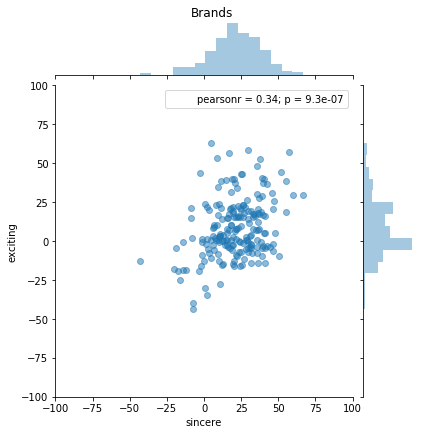

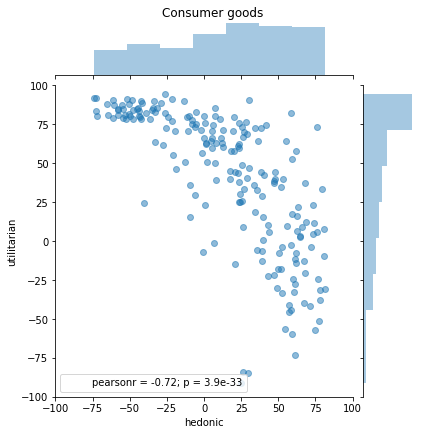

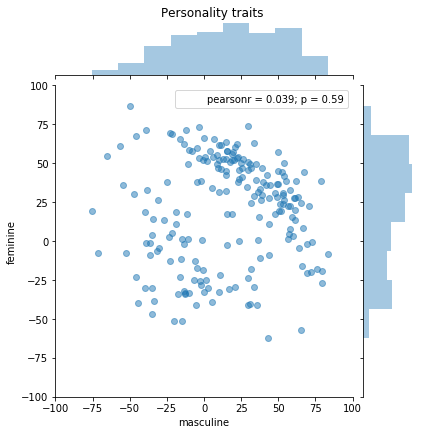

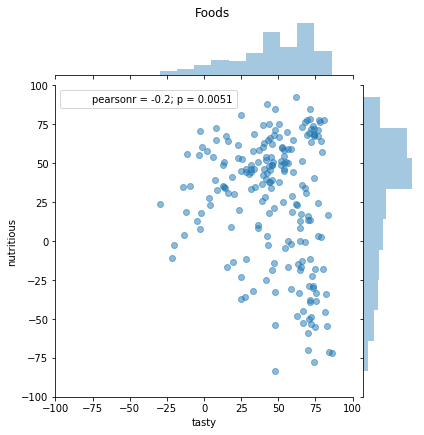

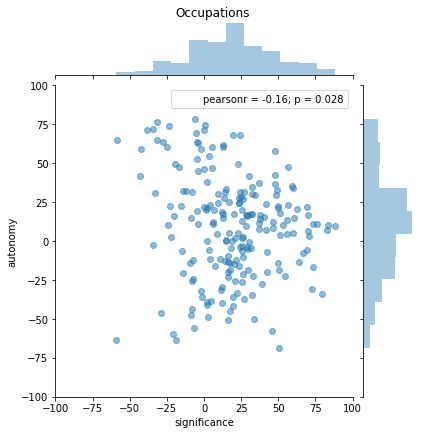

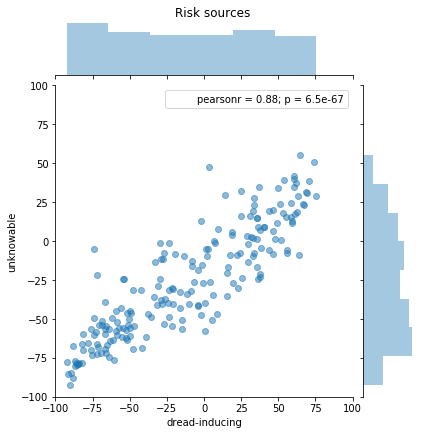

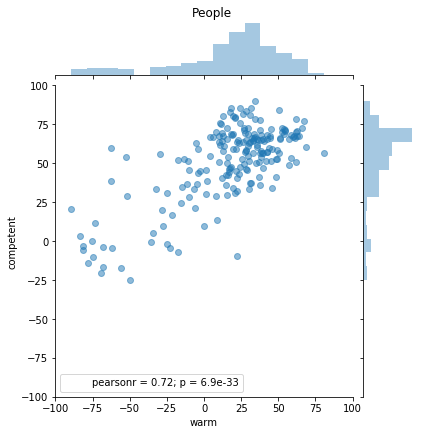

In [23]:
for domain, dim_pair, scatterplot_title in zip(domains, dims, scatterplot_titles):
    df = dict_of_dfs[domain]
    means = df.mean()
    h = sns.jointplot(x=means[dim_pair[0]], y=means[dim_pair[1]], stat_func=pearsonr, xlim=(-100, 100), ylim=(-100,100), alpha=.5)
    h.set_axis_labels(dim_pair[0], dim_pair[1])
    h.fig.suptitle(scatterplot_title, y=1)
    plt.savefig(f'figures/mean_judgment_scatterplots/{domain}.png')
    plt.show()

In [24]:
domains

['brand', 'good', 'trait', 'food', 'occupation', 'risk', 'people']

In [25]:
dims

[('sincere', 'exciting'),
 ('hedonic', 'utilitarian'),
 ('masculine', 'feminine'),
 ('tasty', 'nutritious'),
 ('significance', 'autonomy'),
 ('dread-inducing', 'unknowable'),
 ('warm', 'competent')]

In [26]:
scatterplot_titles

['Brands',
 'Consumer goods',
 'Personality traits',
 'Foods',
 'Occupations',
 'Risk sources',
 'People']

In [27]:
domains = ['trait', 'risk', 'people', 'food', 'occupation', 'brand', 'good']
dims = [('masculine', 'feminine'),
       ('dread-inducing', 'unknowable'),
       ('warm', 'competent'),
       ('tasty', 'nutritious'),
       ('significance', 'autonomy'),
       ('sincere', 'exciting'),
       ('hedonic', 'utilitarian')]
scatterplot_titles = ['Personality traits', 'Risk sources', 'People', 'Foods', 'Occupations', 'Brands', 'Consumer goods']

In [29]:
dict_of_dfs['good'].T

,,Participant_0,Participant_1,Participant_2,Participant_3,Participant_4,Participant_5,Participant_6,Participant_7,Participant_8,Participant_9,...,Participant_39,Participant_40,Participant_42,Participant_43,Participant_44,Participant_45,Participant_46,Participant_47,Participant_48,Participant_49
Judgment,Word,,,,,,,,,,,,,,,,,,,,,
hedonic,hat,62,100,31,49,82,23,20,39,33,37,...,38,7,40,50,100,37,25,61,5,83
utilitarian,hat,74,100,100,88,80,54,-18,100,-25,10,...,-55,10,40,100,71,86,25,100,30,79
hedonic,nightgown,45,21,38,54,81,18,100,25,-63,8,...,51,-19,100,100,100,28,75,48,10,66
utilitarian,nightgown,-61,100,53,-78,-81,23,-98,75,-81,26,...,20,5,100,-95,21,39,0,59,10,62
hedonic,skirt,100,61,43,69,80,15,60,65,28,52,...,97,-31,40,65,42,35,25,73,35,67
utilitarian,skirt,-47,100,57,-43,61,26,-54,81,100,-8,...,14,16,100,100,40,22,50,65,20,20
hedonic,ink,-90,-100,29,46,-100,8,-36,3,20,2,...,-41,-30,-19,-90,-100,-71,-75,13,-100,77
utilitarian,ink,80,100,100,67,100,26,41,100,100,31,...,68,29,99,100,100,72,100,81,100,62
hedonic,ski,100,50,100,75,91,21,87,23,30,41,...,72,64,100,100,83,90,75,100,80,60


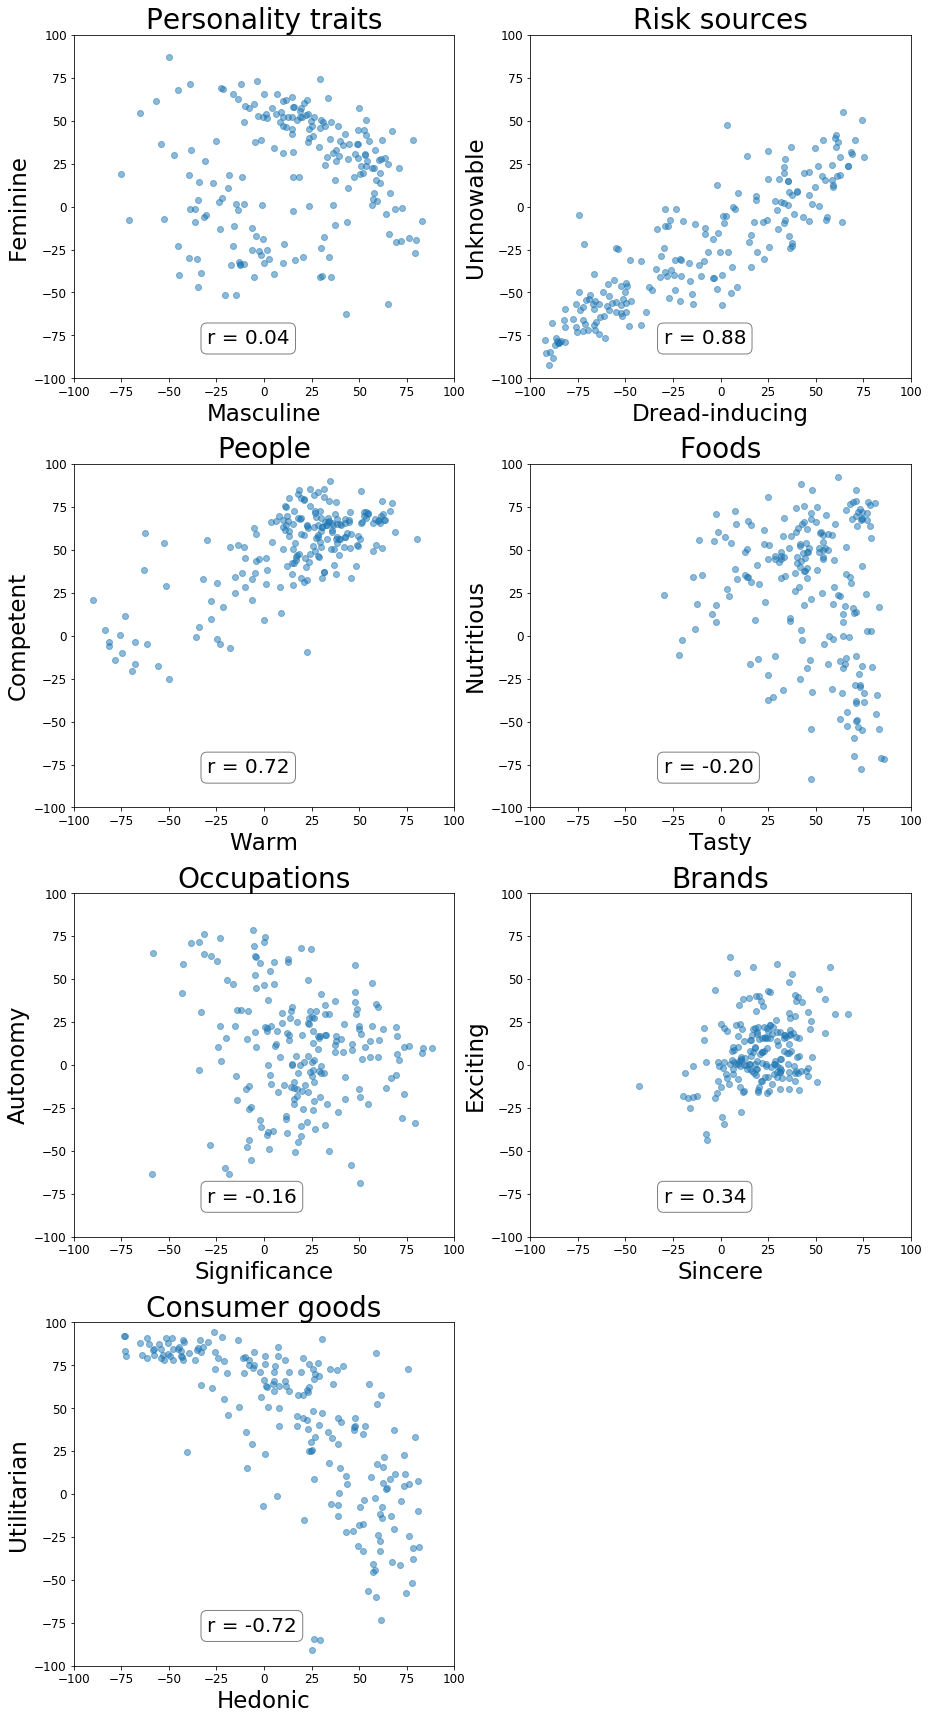

In [26]:
fig, ax_array = plt.subplots(nrows=4, ncols=2, figsize=(15,30))

bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="grey", lw=1)

for ax, domain, dim_pair, scatterplot_title in zip(fig.axes, domains, dims, scatterplot_titles):
    df = dict_of_dfs[domain]
    means = df.mean()
    ax.scatter(x=means[dim_pair[0]], y=means[dim_pair[1]], alpha=.5)
    ax.set_xlim((-100,100))
    ax.set_ylim((-100,100))
        
    r, _= pearsonr(x=means[dim_pair[0]], y=means[dim_pair[1]])
    ax.text(x=-30, y=-80, s="r = {:.2f}".format(r), size=20, bbox=bbox_props)

    dim_pair = [x.capitalize() for x in dim_pair]
    ax.set_xlabel(dim_pair[0], size=23)
    ax.set_ylabel(dim_pair[1], size=23)
    
    ax.set_title(scatterplot_title, size=28)
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    
ax = fig.axes[-1]
fig.delaxes(ax)
plt.subplots_adjust(hspace=0.25)
plt.savefig('figures/mean_judgment_scatterplots.png')

# Variability across participants in judgments

In [27]:
# for domain, pair_of_dims in zip(domains, dims):
#     print(domain)
#     for dim in pair_of_dims:
#         print(dim)
#         dict_of_dfs[domain][dim].std().hist();
#         plt.show()

In [28]:
for domain, pair_of_dims in zip(domains, dims):
    print('\n',domain, sep='')
    for dim in pair_of_dims:
        print(dim)
        print(dict_of_dfs[domain][dim].std().describe())


trait
masculine
count    200.000000
mean      46.245824
std        6.653493
min       23.748325
25%       42.092411
50%       46.091449
75%       50.560931
max       60.918562
dtype: float64
feminine
count    200.000000
mean      45.245804
std        7.076047
min       24.838318
25%       41.124102
50%       45.244809
75%       50.289774
max       61.300976
dtype: float64

risk
dread-inducing
count    200.000000
mean      48.854042
std        9.918004
min       16.803380
25%       43.341781
50%       49.351725
75%       57.020055
max       66.004463
dtype: float64
unknowable
count    200.000000
mean      57.815883
std        8.769400
min       21.223464
25%       53.341402
50%       59.876212
75%       63.824627
max       75.491344
dtype: float64

people
warm
count    200.000000
mean      40.072936
std        7.448808
min       27.159961
25%       35.050599
50%       38.961171
75%       44.614614
max       60.486239
dtype: float64
competent
count    200.000000
mean      38.256950
std 

# Saving dict_of_dfs for further analysis

In [29]:
with open("data/dict_of_dfs.pickle", "wb") as handle:
    pickle.dump(dict_of_dfs, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [30]:
# with open("data/dict_of_dfs_no_items_or_participants_dropped.pickle", "wb") as handle:
#     pickle.dump(dict_of_dfs, handle, protocol=pickle.HIGHEST_PROTOCOL)